<a href="https://colab.research.google.com/github/Lisker2/ML/blob/main/Project/ProteinBert_A_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/nadavbra/shared_utils.git
!git clone https://github.com/nadavbra/protein_bert
!git clone https://github.com/khanhlee/bert-enhancer
!pip install protein-bert

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
from proteinbert import load_pretrained_model

In [4]:
train = pd.read_csv('protein_bert/protein_benchmarks/stability.train.csv')[:10000]
valid = pd.read_csv('protein_bert/protein_benchmarks/stability.valid.csv')[:1000]
test = pd.read_csv('protein_bert/protein_benchmarks/stability.test.csv')[:1000]

train_X = train['seq']
valid_X = valid['seq']
test_X = test['seq']

In [15]:
train_Y = train['label']
valid_Y = valid['label']
test_Y = test['label']

In [5]:
train.head()

,seq,label
0,DQSVRKLVRKLPDEGLDREKVKTYLDKLGVDREELQKFSDAIGLES...,-0.21
1,GSSDIEITVEGKEQADKVIEEMKRRNLEVHVEEHNGQYIDKASLES...,-0.95
2,GSSTERRTFDDETQARKAAEEAKKKGLQVTVTKENGQYHVDFN,0.42
3,MLDDFTHELMLDDFTHELMLDDFTHELMLDDFTHELSSNGGGSNGS...,0.10
4,GSSTQTITTTNKENAEQIAREAKKKGLDVTIRKNNGTWEIHWD,0.76


In [6]:
sequence_length = max(train.seq.map(lambda x: len(x)).max(), 
             test.seq.map(lambda x: len(x)).max(), 
             valid.seq.map(lambda x: len(x)).max()) + 2
print('sequence_length', sequence_length)

sequence_length 52


In [9]:
pretrained_model_generator, input_encoder = load_pretrained_model("/content/")

In [8]:
print(type(train_X))
print(train_X.shape)

<class 'pandas.core.series.Series'>
(10000,)


In [9]:
train_X = input_encoder.encode_X(train_X, sequence_length)
valid_X = input_encoder.encode_X(valid_X, sequence_length)
test_X = input_encoder.encode_X(test_X, sequence_length)

In [10]:
model_generator = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(sequence_length))

In [11]:
local_representations_train, global_representations_train= model_generator.predict(train_X, batch_size = 64)
local_representations_valid, global_representations_valid= model_generator.predict(valid_X, batch_size = 64)
local_representations_test, global_representations_test= model_generator.predict(test_X, batch_size = 64)

16/16 [==============================] - 1s 85ms/step


In [12]:
print(local_representations_train.shape)

(10000, 52, 1562)


In [21]:
model_stability = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = local_representations_train[0].shape),
    
    tf.keras.layers.Dense(1, activation = 'linear')]
)
model_stability.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'])
training_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-10, verbose = 1),
    tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]
history_stability = model_stability.fit(local_representations_train, train_Y, 
                                validation_data=(local_representations_valid, valid_Y), 
                                batch_size=64, epochs=30,
                                callbacks=training_callbacks)

Epoch 1/30
157/157 [==============================] - 3s 15ms/step - loss: 0.6546 - mse: 0.6546 - val_loss: 0.2572 - val_mse: 0.2572 - lr: 0.0010
Epoch 2/30
153/157 [============================>.] - ETA: 0s - loss: 0.2762 - mse: 0.2762
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
157/157 [==============================] - 1s 9ms/step - loss: 0.2765 - mse: 0.2765 - val_loss: 0.2948 - val_mse: 0.2948 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 1s 9ms/step - loss: 0.2049 - mse: 0.2049 - val_loss: 0.2422 - val_mse: 0.2422 - lr: 2.5000e-04
Epoch 4/30
155/157 [============================>.] - ETA: 0s - loss: 0.1832 - mse: 0.1832
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
157/157 [==============================] - 1s 9ms/step - loss: 0.1828 - mse: 0.1828 - val_loss: 0.2471 - val_mse: 0.2471 - lr: 2.5000e-04
Epoch 5/30
157/157 [==============================] - 1s 9ms/step - loss: 0.1638 - mse: 0.1638 - val

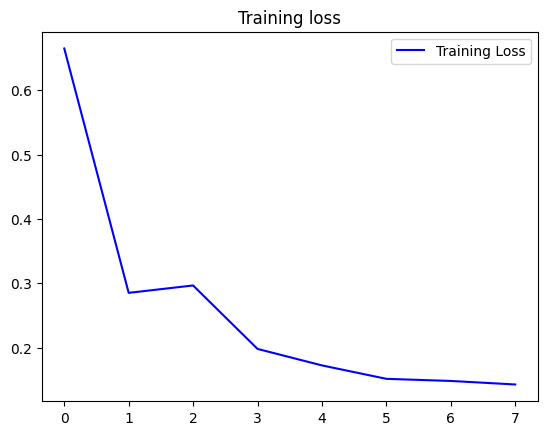

In [17]:
loss = history_stability.history['loss']

plt.plot(range(len(loss)), loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

In [19]:
predict_Y = model_stability.predict(local_representations_test)
p, _ = spearmanr(predict_Y, test_Y)
print(p)

32/32 [==============================] - 0s 3ms/step
0.41706737486869766


In [ ]:
model_stability_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(52, 1562, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(16, activation='relu'), 
    tf.keras.layers.Dense(1, activation = 'linear')]
)
model_stability_cnn.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'])
training_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-10, verbose = 1),
    tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]
history_stability_cnn = model_stability_cnn.fit(local_representations_train, train_Y, 
                                validation_data=(local_representations_valid, valid_Y), 
                                batch_size=64, epochs=30,
                                callbacks=training_callbacks)

Epoch 1/30
157/157 [==============================] - 49s 306ms/step - loss: 0.8210 - mse: 0.8210 - val_loss: 0.5036 - val_mse: 0.5036 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 48s 306ms/step - loss: 0.3452 - mse: 0.3452 - val_loss: 0.4873 - val_mse: 0.4873 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 48s 305ms/step - loss: 0.3358 - mse: 0.3358 - val_loss: 0.4732 - val_mse: 0.4732 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 48s 303ms/step - loss: 0.3302 - mse: 0.3302 - val_loss: 0.4637 - val_mse: 0.4637 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 48s 304ms/step - loss: 0.3276 - mse: 0.3276 - val_loss: 0.4584 - val_mse: 0.4584 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 47s 302ms/step - loss: 0.3266 - mse: 0.3266 - val_loss: 0.4554 - val_mse: 0.4554 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 48s 304ms/step - loss: 0.3263 - mse: 0.3263 - val_loss: 0.

In [3]:
non_cv = pd.read_csv('bert-enhancer/data/non.cv.txt')[::2]
non_cv.columns = ['seq']
print((len(non_cv)))

label_1 = [0 for i in range(len(non_cv))]
non_cv['label'] = label_1

enhancer_cv = pd.read_csv('bert-enhancer/data/enhancer.cv.txt')[::2]
enhancer_cv.columns = ['seq']
print((len(enhancer_cv)))

label_1 = [1 for i in range(len(enhancer_cv))]
enhancer_cv['label'] = label_1

1484
1484


In [4]:
enhancer_train = pd.concat([non_cv, enhancer_cv],axis=0)
enhancer_train.index = range(len(enhancer_train))
enhancer_train.head()

,seq,label
0,ATGCAAAATGGGAATGCATGAGACAGGTGGGAAAGAGAGGGAGAAA...,0
1,TCTGAAGGGGTTAAGTCAAAGATATATGGATTCACTAGACCTAGAG...,0
2,CAGGAGAATCGCTTGAGCCCGGGAGGCGGAGGTTGCAGTGAGCAGA...,0
3,AAGTAAAAGGATGGAAAAAGATGTATAATACAAGCATTAATCACGA...,0
4,AGCAAGACTAATAAAGAAAAAAAGAGAGAAGAATCAAATAGATGCA...,0


In [5]:
non_ind = pd.read_csv('bert-enhancer/data/non.ind.txt')[::2]
non_ind.columns = ['seq']
print((len(non_ind)))

label_1 = [0 for i in range(len(non_ind))]
non_ind['label'] = label_1

enhancer_ind = pd.read_csv('bert-enhancer/data/enhancer.ind.txt')[::2]
enhancer_ind.columns = ['seq']
print((len(enhancer_ind)))

label_1 = [1 for i in range(len(enhancer_ind))]
enhancer_ind['label'] = label_1

200
200


In [6]:
enhancer_test = pd.concat([non_ind, enhancer_ind],axis=0)
enhancer_test.index = range(len(enhancer_test))
enhancer_test.head()

,seq,label
0,AATTTTCTCATTTTCTCATAAAGTTTAACAGTTGTTTATTTGAGTC...,0
1,ACTGGTTATCTTTTAGGACTAGTTAATATAACCCATTCTCTAACCA...,0
2,ATGCATATGTTCTTCAGTAAACAGAGCAGCCACTGGTACCACAGGA...,0
3,CTGCTCTCCTCGCTCTATAAAAGTCAGAGTGCCTAAGCTGTTAATT...,0
4,GCTTGGGTATATATTGTCCAATATAGCAGGCCTCATGTGCTCCTTA...,0


In [7]:
enhancer_sequence_length = enhancer_train['seq'].map(lambda x: len(x)).max() + 2
print('sequence_length', enhancer_sequence_length)

sequence_length 202


In [10]:
enhancer_train_X = input_encoder.encode_X(enhancer_train['seq'], enhancer_sequence_length)
enhancer_test_X = input_encoder.encode_X(enhancer_test['seq'], enhancer_sequence_length)

In [11]:
enhancer_model_generator = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(enhancer_sequence_length))

In [12]:
enhancer_local_representations_train, global_representations_train=enhancer_model_generator.predict(enhancer_train_X, batch_size = 64)
enhancer_local_representations_test, global_representations_test=enhancer_model_generator.predict(enhancer_test_X, batch_size = 64)

7/7 [==============================] - 1s 157ms/step


In [ ]:
model_enhancer = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = enhancer_local_representations_train[0].shape),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
model_enhancer.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

history_stability = model_enhancer.fit(enhancer_local_representations_train, enhancer_train['label'], 
                                batch_size=64, epochs=50)

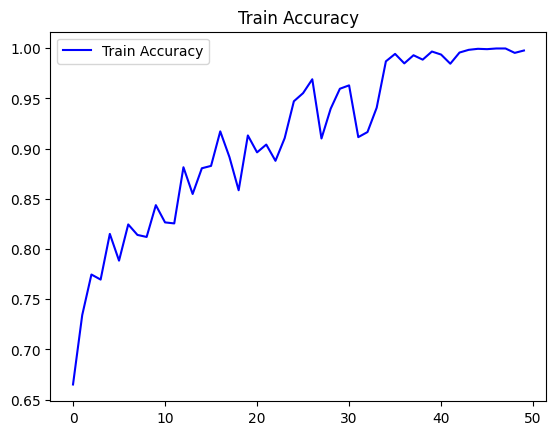

In [48]:
accuracy = history_stability .history['accuracy']

plt.plot(range(len(accuracy)), accuracy, 'b', label='Train Accuracy')
plt.title('Train Accuracy')
plt.legend()

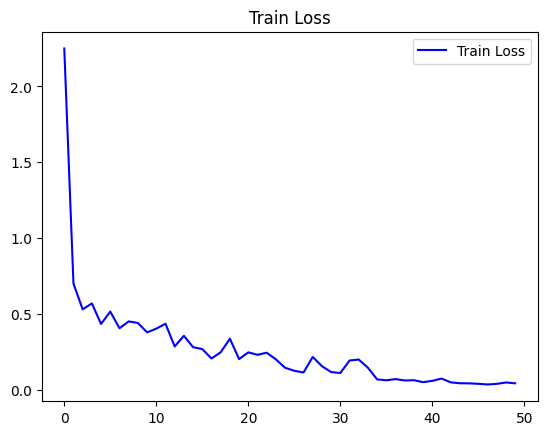

In [49]:
loss = history_stability .history['loss']

plt.plot(range(len(loss)), loss, 'b', label='Train Loss')
plt.title('Train Loss')
plt.legend()

In [42]:
enhancer_predict_Y = model_enhancer.predict(enhancer_local_representations_test)
label = []
for i in enhancer_predict_Y:
  if i[0] <= 0.5:
    label.append(0)
  else:
    label.append(1)
correct = 0
for i in range(len(label)):
  if label[i] == enhancer_test['label'][i]:
    correct += 1
correct / len(label)

13/13 [==============================] - 0s 6ms/step


0.775

In [ ]:
'''
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.sequence import pad_sequences
'''

In [ ]:
'''
train = pd.read_csv('protein_bert/protein_benchmarks/stability.train.csv')[:2000]
valid = pd.read_csv('protein_bert/protein_benchmarks/stability.valid.csv')[:300]
test = pd.read_csv('protein_bert/protein_benchmarks/stability.test.csv')[:300]

train_X = train['seq']
valid_X = valid['seq']
test_X = test['seq']

padded_sequences = pad_sequences(train_X, maxlen=75, padding='pre')

'''

In [ ]:
'''
print(local_representations_train.shape)
zeros = np.array([np.zeros(1562) for _ in range(23)]).reshape(1, 23, 1562)
print(zeros.shape)
local_representations_train = np.append(local_representations_train, values = zeros, axis = 2)
print(local_representations_train.shape)
'''

In [ ]:
'''
pre_trained_cnn = InceptionV3(input_shape = (52, 1562, 1),
                                  include_top = False, 
                                  weights = None).load_weights('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

pre_trained_cnn.summary()
'''